In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [2]:
books = pd.read_csv("BX-Books.csv")
ratings =  pd.read_csv("BX-Ratings.csv")
users =  pd.read_csv("BX-Users.csv")

Text(0, 0.5, 'The Amount of Publication')

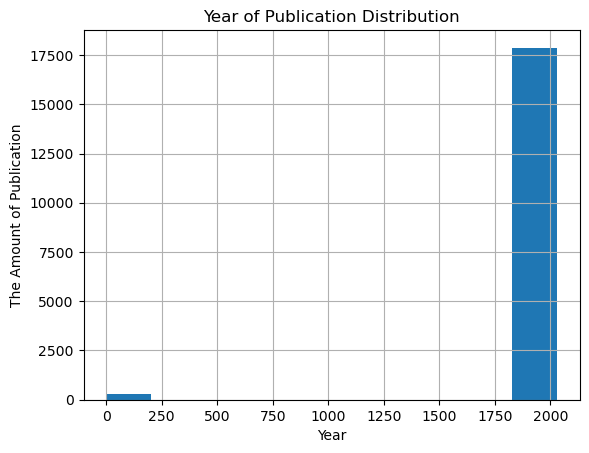

In [3]:
# visualize raw dataset year of publication
books["Year-Of-Publication"].hist(bins=10)
plt.title("Year of Publication Distribution")
plt.xlabel("Year")
plt.ylabel("The Amount of Publication")


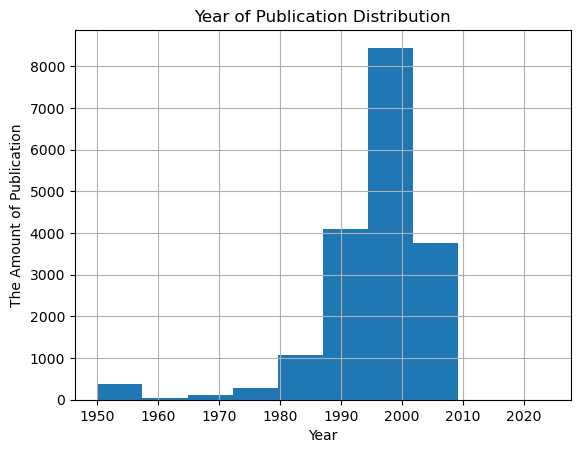

In [4]:
# fix error found above
books["Year-Of-Publication"] = books["Year-Of-Publication"].clip(upper=2024, lower=1950)

books["Year-Of-Publication"].hist(bins=10)
plt.title("Year of Publication Distribution")
plt.xlabel("Year")
plt.ylabel("The Amount of Publication")
plt.show()


In [5]:
# convert continuous data to discrete variables
bins = [ 1950,1960,1970,1980,1990,2000,2010,2020,2030 ]
books["Year-Of-Publication-Bin"] = pd.cut(books["Year-Of-Publication"],bins=bins, right=False)

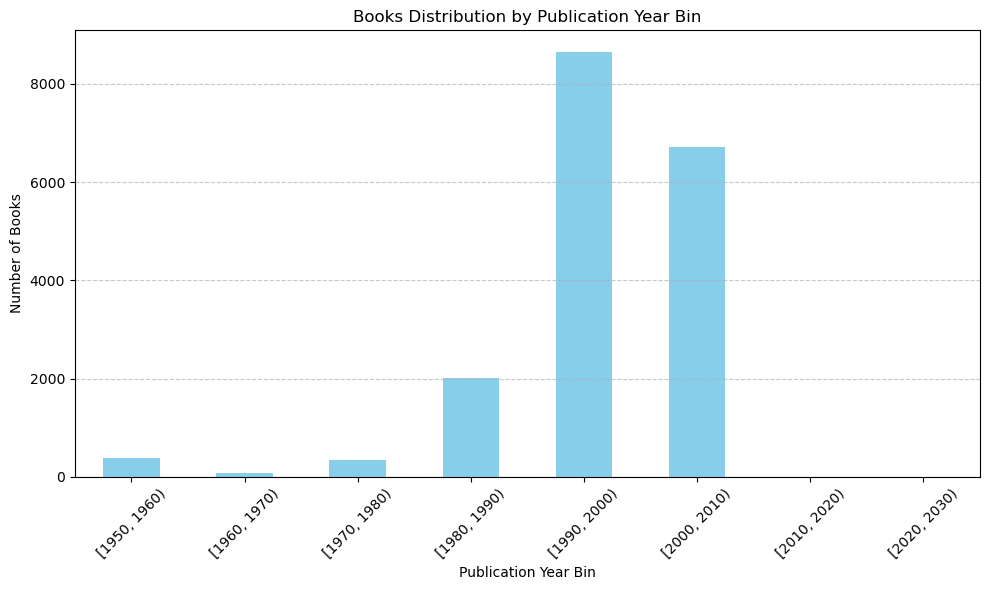

In [6]:
# visualize modified publication year
books_by_year_bin = books["Year-Of-Publication-Bin"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
books_by_year_bin.plot(kind='bar', color='skyblue')
plt.title('Books Distribution by Publication Year Bin')
plt.xlabel('Publication Year Bin')
plt.ylabel('Number of Books')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
# count missing data
missing_values = users.isna().sum()
print(missing_values)

User-ID             0
User-City          61
User-State          0
User-Country      669
User-Age        18952
dtype: int64


In [8]:
# delete rows with missing city data
users.drop(["User-City"],axis=1,inplace=True)

In [9]:
# fill in missing country data by matching same state
users["User-Country"] = users["User-Country"].str.replace('"',"").str.strip()
users["User-Country"] = users["User-Country"].str.lower().replace("",pd.NA)

missing_countries = users[users["User-Country"].isnull()]
existing_countries = users.dropna(subset=["User-Country"])

state_find_countries = existing_countries.groupby("User-State")["User-Country"].first().to_dict()

for i,j in missing_countries.iterrows():
    state = j["User-State"]
    if state in state_find_countries:
        users.at[i,"User-Country"] = state_find_countries[state]

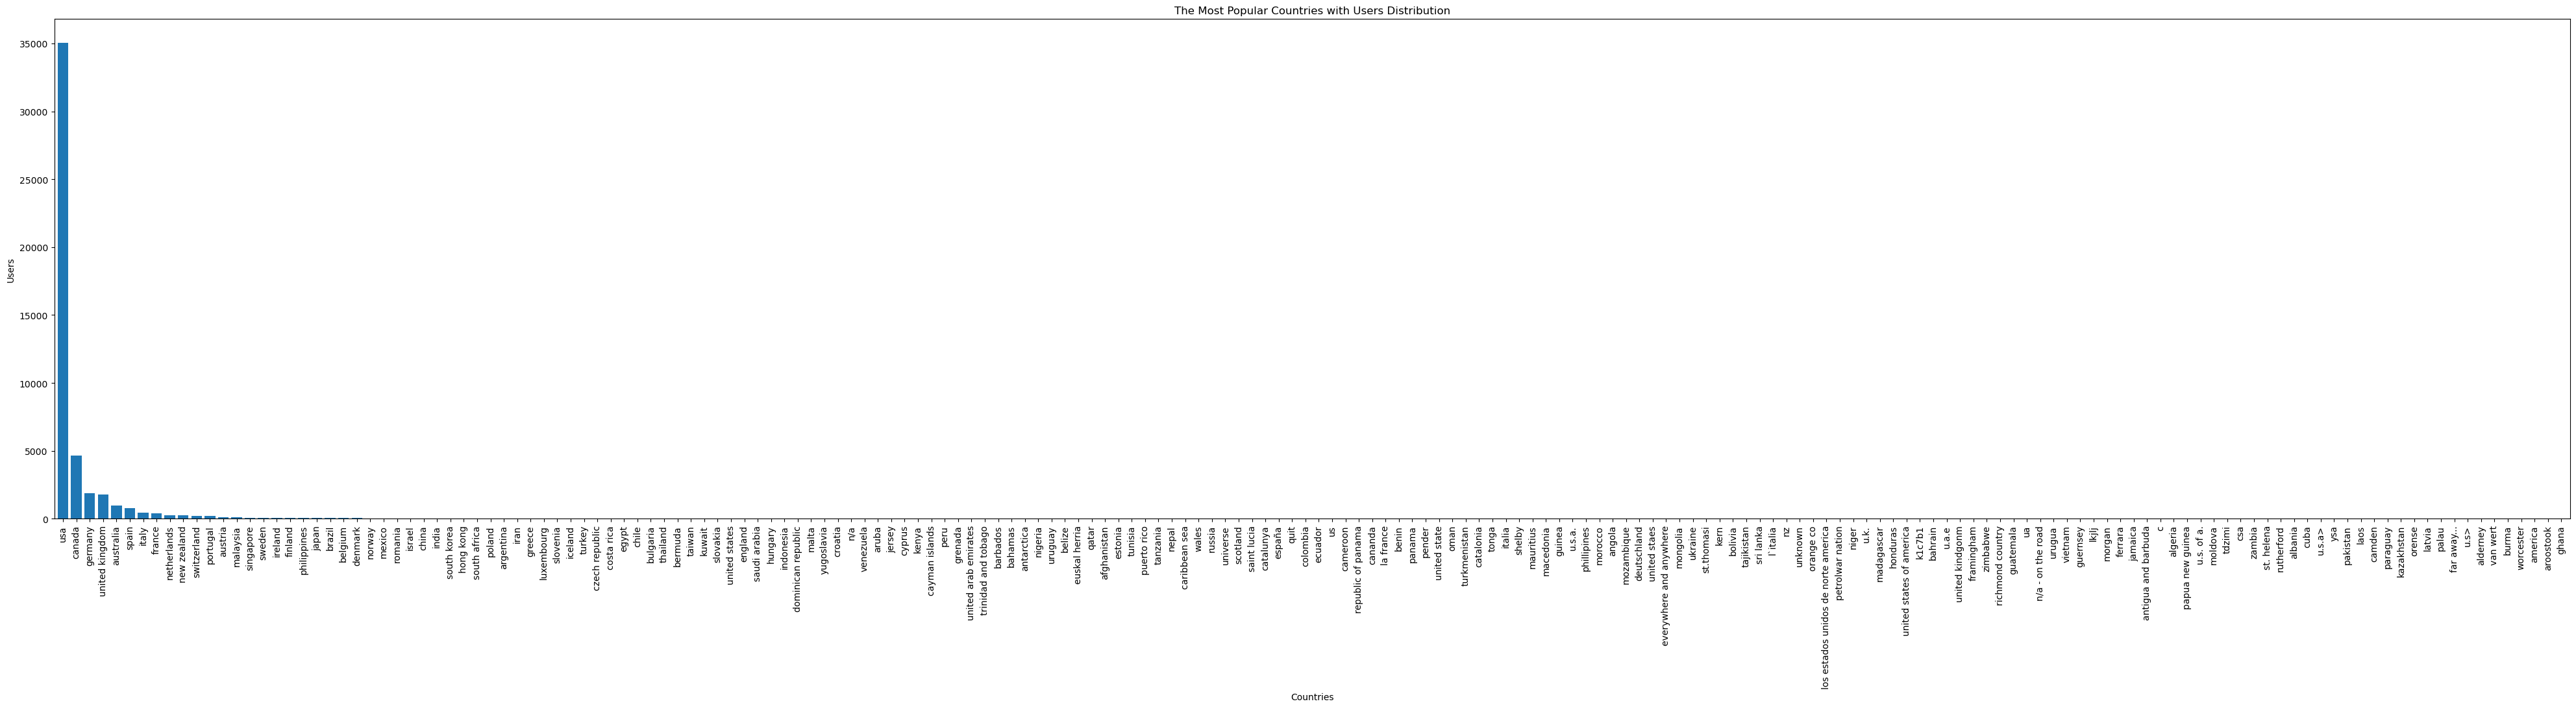

In [10]:
# country dataset before resharping
most_popular_countries = users["User-Country"].value_counts()[users["User-Country"].value_counts() > 0].index
plt.figure(figsize=(50,10)) 
users["User-Country"].value_counts()[most_popular_countries].plot(kind="bar", width=0.8) 
plt.title("The Most Popular Countries with Users Distribution")
plt.xlabel("Countries")
plt.ylabel("Users")
plt.show()


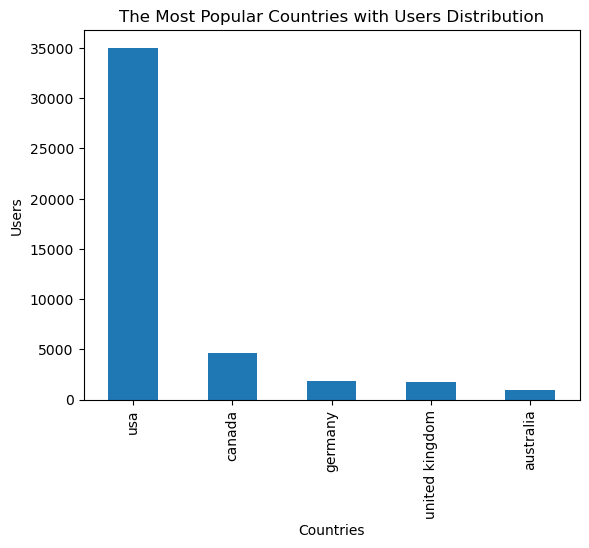

In [11]:
# only keep countries with > 800 frequencies
most_popular_countries = users["User-Country"].value_counts()[users["User-Country"].value_counts() > 800].index

# resulting top 5 countries
users["User-Country"].value_counts()[most_popular_countries].plot(kind="bar")
plt.title("The Most Popular Countries with Users Distribution")
plt.xlabel("Countries")
plt.ylabel("Users")
plt.show()


In [12]:
# find the top 6 states in the 5 countries
top_states_per_country = users.groupby("User-Country")["User-State"].value_counts().groupby(level=0).head(6)
top_five_countries = users["User-Country"].value_counts().head(5).index
top_states_dict = {}
for country in top_five_countries:
    top_states_dict[country] = top_states_per_country.loc[country].index.tolist()

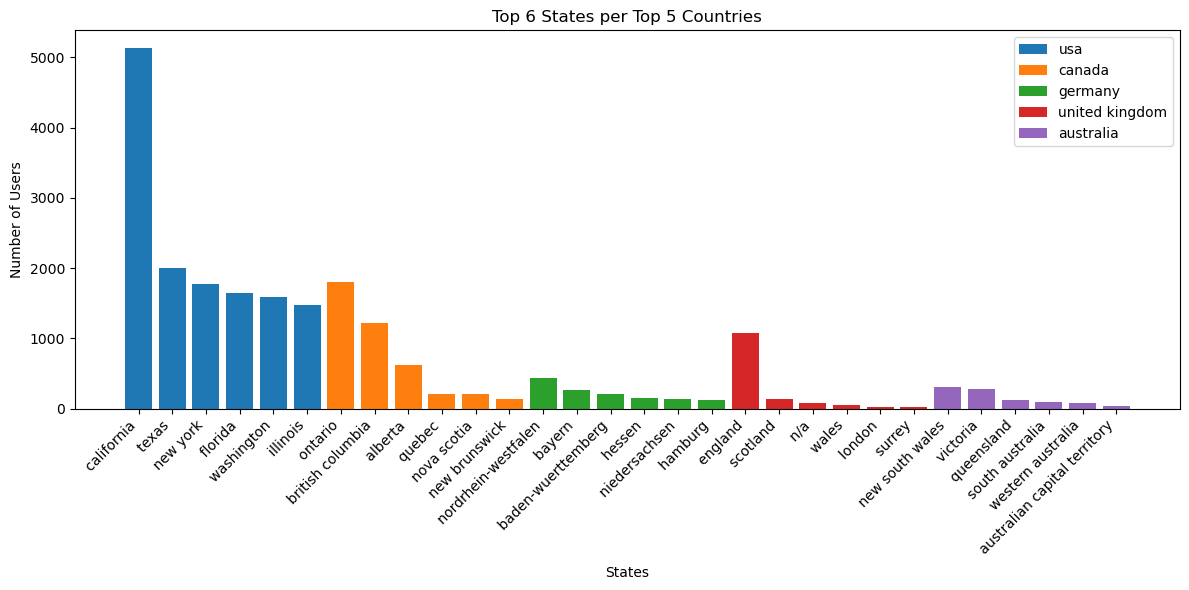

In [13]:
# plotting the bar chart
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
for country, states in top_states_dict.items():
    plt.bar(states, top_states_per_country.loc[country].values, label=country)

plt.xlabel('States')
plt.ylabel('Number of Users')
plt.title('Top 6 States per Top 5 Countries')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


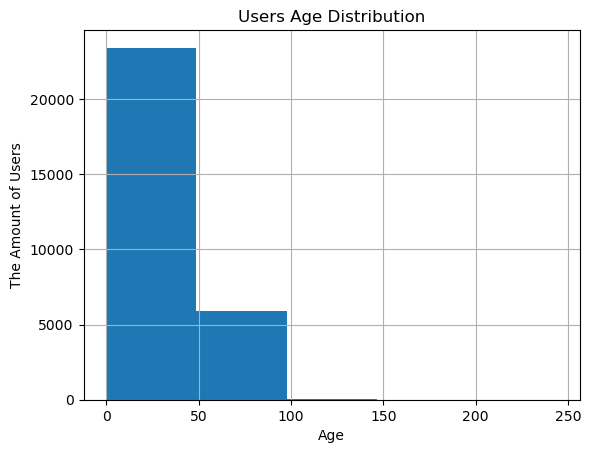

In [14]:
# visualize raw dataset age of users
users["User-Age"] = users["User-Age"].str.replace('"', "")
users["User-Age"] = users["User-Age"].replace("NaN", pd.NA)
users["User-Age"] = pd.to_numeric(users["User-Age"], errors='coerce')

users["User-Age"].hist(bins=5)
plt.title("Users Age Distribution")
plt.xlabel("Age")
plt.ylabel("The Amount of Users")
plt.show()

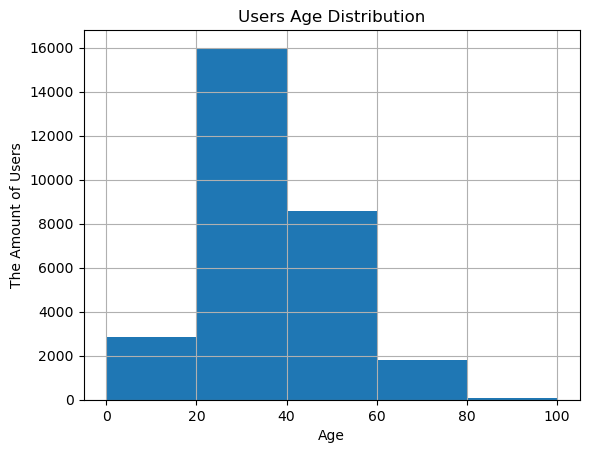

In [15]:
# remove unreasonable age 
# missing data not included
users["User-Age"] = users["User-Age"].astype(str).str.replace('"', "")
users["User-Age"] = users["User-Age"].replace("NaN", pd.NA)
users["User-Age"] = pd.to_numeric(users["User-Age"], errors='coerce')
users["User-Age"] = users["User-Age"].astype("Int64").clip(upper=100)

# histogram of age distribution
users["User-Age"].hist(bins=5)
plt.title("Users Age Distribution")
plt.xlabel("Age")
plt.ylabel("The Amount of Users")
plt.show()

<Axes: xlabel='User-Age-Bin'>

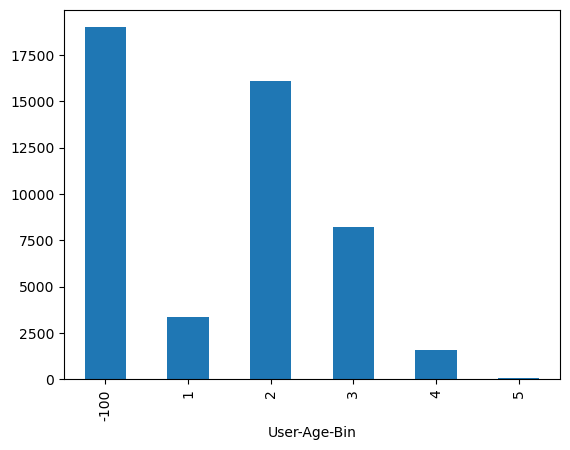

In [16]:
# replace missing ages with -100
# convert continuous age to discrete variables 1 2 3 4 5
bins=[-float("inf"),0,20,40,60,80,100] # 0 1 2 3 4 5 是 -100,20,40,60,80,100
labels=[-100,1,2,3,4,5]

users["User-Age"].fillna(-100,inplace=True)
users["User-Age-Bin"] = pd.cut(users["User-Age"],bins= bins,labels= labels, include_lowest= True)
users["User-Age-Bin"].value_counts().sort_index().plot(kind="bar")

In [17]:
# end of data processing implement the dataset to models

In [18]:
# convert non-numerical data to numerical
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
users["User-State-Encoded"] = label_encoder.fit_transform(users["User-State"])
users["User-Country-Encoded"] = label_encoder.fit_transform(users["User-Country"])

In [19]:
# check if it only contains numbers
users_finished = users[["User-ID","User-Age","User-Age-Bin","User-State-Encoded","User-Country-Encoded"]]
users_finished.head() 

,User-ID,User-Age,User-Age-Bin,User-State-Encoded,User-Country-Encoded
0,8,-100,-100,715,27
1,9,-100,-100,942,178
2,16,-100,-100,639,178
3,17,-100,-100,1012,178
4,19,14,1,0,178


In [20]:
from sklearn.preprocessing import LabelEncoder

# initialize LabelEncoder
label_encoder = LabelEncoder()

# encode categorical features
books["Book-Author-Encoded"] = label_encoder.fit_transform(books["Book-Author"])
books["Book-Publisher-Encoded"] = label_encoder.fit_transform(books["Book-Publisher"])
books["Year-Of-Publication-Bin"] = label_encoder.fit_transform(books["Year-Of-Publication-Bin"])

books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Year-Of-Publication-Bin,Book-Author-Encoded,Book-Publisher-Encoded
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,5,5190,522
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,4,2169,406
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,4,240,952
3,0440234743,The Testament,John Grisham,1999,Dell,4,3079,287
4,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume,4,6132,910


In [21]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import nltk
from nltk import downloader

nltk.download('punkt')

import nltk
nltk.download('stopwords')

import nltk
nltk.download('wordnet')

# some device may need to import to run the folowing code

[nltk_data] Downloading package punkt to /Users/yo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
# simplify book title for analysing book theme

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))
# delete preposition and meaningless words
prepositions = set(["a", "about", "an", "as", "at", "between","by", "down", "during", "for", 
                    "from", "in", "like", "of", "off", "on", "over", "the", "through", "to", "with", ])
special_word = set(["story","book","novel","paperback"])

def preprocess_text(text):
    text = str(text).lower()
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    tokens = word_tokenize(letters_only)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in 
              (prepositions and special_word)]
    
    text = " ".join(tokens)
    return text

# also deal with author and publisher
books["Book-Title"] = books["Book-Title"].apply(preprocess_text)
books["Book-Author"] = books["Book-Author"].apply(preprocess_text)
books["Book-Publisher"] = books["Book-Publisher"].apply(preprocess_text)

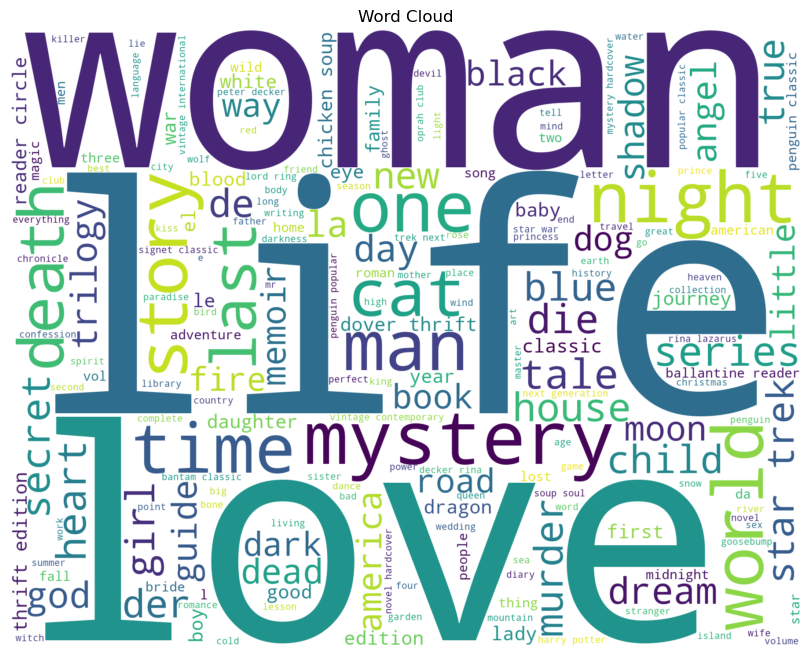

In [23]:
# show theme popularity in word cloud
combined_text = books["Book-Title"]

wordcloud = WordCloud(width= 1800, height= 1400, background_color = "white").generate(" ".join(combined_text))

plt.figure(figsize = (12,8))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud")
plt.show()

In [24]:
# test variability -- how many originial data is included
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import numpy as np

tokenized_titles = [title.split() for title in books["Book-Title"]+books["Book-Author"]+books["Book-Publisher"]]

# train Word2Vec model 
model = Word2Vec(sentences=tokenized_titles, vector_size=1000, window=5, min_count=1, workers=4)

# get Word2Vec embeddings for each title
embeddings = []
for title in tokenized_titles:
    title_embeddings = [model.wv[word] for word in title if word in model.wv]
    if title_embeddings:
        embeddings.append(np.mean(title_embeddings, axis=0))
    else:
        embeddings.append(np.zeros(100)) # Handle out-of-vocabulary words
        
        
word2vec_df = pd.DataFrame(embeddings)

pca = PCA(n_components=1)
pca.fit(word2vec_df)

# transform to 1 dimension
word2vec_df_pca = pca.transform(word2vec_df)

# percentage of variance
pct_var_explained = pca.explained_variance_ratio_

print(f"\nTotal percentage of variance by {len(pct_var_explained)} components: {sum(pct_var_explained)*100:.2f}%")


Total percentage of variance by 1 components: 99.39%


In [25]:
# add new attributes for book dataset
books_finished = books[["ISBN", "Year-Of-Publication", "Year-Of-Publication-Bin", "Book-Author-Encoded", "Book-Publisher-Encoded"]]
books_finished["embedding"] = word2vec_df_pca
books_finished.head()

/var/folders/sc/pg_6718n3l3g8xsqgw7vz32c0000gn/T/ipykernel_18787/1824627294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_finished["embedding"] = word2vec_df_pca


,ISBN,Year-Of-Publication,Year-Of-Publication-Bin,Book-Author-Encoded,Book-Publisher-Encoded,embedding
0,0002005018,2001,5,5190,522,-0.432540
1,0374157065,1999,4,2169,406,-0.296018
2,0399135782,1991,4,240,952,0.011500
3,0440234743,1999,4,3079,287,-0.437216
4,0452264464,1994,4,6132,910,-0.276968


In [26]:
# merging dataset 
# merge ratings & books
merged_data = pd.merge(ratings, books_finished, on="ISBN", how="inner")

# merge merged_data & users
merged_data = pd.merge(merged_data, users_finished, on="User-ID", how="inner")

# drop useless column to enhance efficiency
# check user-state & user-country
merged_data = merged_data.drop(columns=["User-ID", "ISBN"])
merged_data

,Book-Rating,Year-Of-Publication,Year-Of-Publication-Bin,Book-Author-Encoded,Book-Publisher-Encoded,embedding,User-Age,User-Age-Bin,User-State-Encoded,User-Country-Encoded
0,7,2001,5,2556,325,-0.446016,-100,-100,176,178
1,10,2001,5,2556,325,-0.446016,-100,-100,615,101
2,3,1999,4,5762,1062,-0.221129,-100,-100,615,101
3,1,2002,5,3459,1018,-0.332284,-100,-100,615,101
4,9,2003,5,1841,1222,-0.321301,-100,-100,615,101
...,...,...,...,...,...,...,...,...,...,...
204159,10,1998,4,1512,456,-0.350722,-100,-100,795,57
204160,9,2003,5,1856,54,-0.255514,25,2,148,57
204161,10,2003,5,1856,54,-0.255514,-100,-100,1054,147
204162,6,1998,4,1112,850,0.099830,24,2,176,178


In [27]:
# standard scaler to for all numberical dataset 
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

merged_data_scaled = merged_data.copy()

columns_to_scale = ["Year-Of-Publication", "Year-Of-Publication-Bin", "Book-Author-Encoded", "Book-Publisher-Encoded", "embedding", "User-Age", "User-Age-Bin", "User-State-Encoded", "User-Country-Encoded"]

merged_data_scaled[columns_to_scale] = scaler.fit_transform(merged_data[columns_to_scale])
merged_data_scaled

,Book-Rating,Year-Of-Publication,Year-Of-Publication-Bin,Book-Author-Encoded,Book-Publisher-Encoded,embedding,User-Age,User-Age-Bin,User-State-Encoded,User-Country-Encoded
0,7,0.603269,0.897339,-0.373870,-0.786354,-1.344942,-1.504748,-1.524486,-1.257507,0.499701
1,10,0.603269,0.897339,-0.373870,-0.786354,-1.344942,-1.504748,-1.524486,0.234859,-0.942414
2,3,0.362311,-0.227200,1.333644,0.979249,-0.683128,-1.504748,-1.524486,0.234859,-0.942414
3,1,0.723747,0.897339,0.107068,0.873840,-1.010244,-1.504748,-1.524486,0.234859,-0.942414
4,9,0.844226,0.897339,-0.754678,1.362555,-0.977922,-1.504748,-1.524486,0.234859,-0.942414
...,...,...,...,...,...,...,...,...,...,...
204159,10,0.241832,-0.227200,-0.929903,-0.472522,-1.064503,-1.504748,-1.524486,0.846763,-1.766480
204160,9,0.844226,0.897339,-0.746689,-1.435579,-0.784320,0.466487,0.649478,-1.352692,-1.766480
204161,10,0.844226,0.897339,-0.746689,-1.435579,-0.784320,-1.504748,-1.524486,1.727225,-0.080891
204162,6,0.241832,-0.227200,-1.142943,0.471368,0.261412,0.450717,0.649478,-1.257507,0.499701


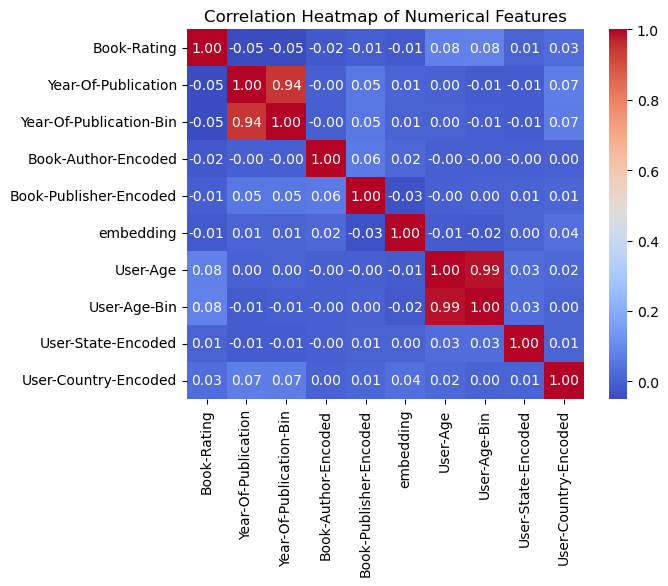

In [28]:
import seaborn as sns
correlation_matrix = merged_data_scaled.corr()
correlation_matrix
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

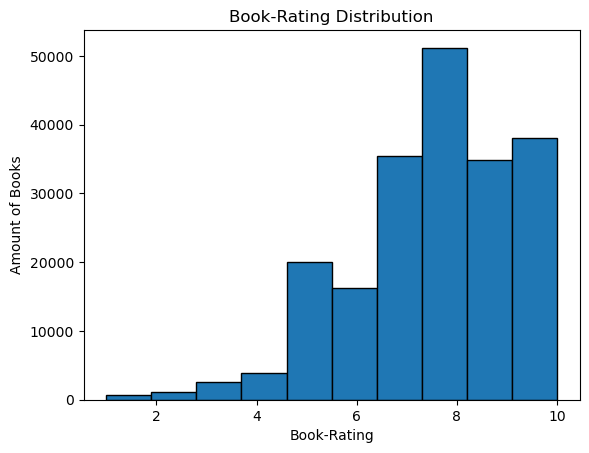

In [29]:
# visualize original rating dataset
plt.hist(merged_data_scaled["Book-Rating"], bins=10, edgecolor="black")
plt.title("Book-Rating Distribution")
plt.xlabel("Book-Rating")
plt.ylabel("Amount of Books")

plt.show()

In [ ]:
# rescale ratings
merged_data_scaled["Rating-Category"] = pd.cut(merged_data_scaled["Book-Rating"], bins=[0, 6, 7, 8, 9, 10], labels=[1, 2, 3, 4, 5], right=True)
rating_counts = merged_data_scaled["Rating-Category"].value_counts().sort_index()
rating_counts.plot(kind="bar")

plt.title("Distribution of Rating Categories")
plt.xlabel("Rating Categories")
plt.ylabel("Amount of Books")

plt.show()
print(merged_data_scaled.head())
merged_data_scaled

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [32]:
x = merged_data_scaled.drop(columns = ["Book-Rating", "Rating-Category", "Book-Author-Encoded", "Book-Publisher-Encoded"])
y = merged_data_scaled["Book-Rating"]

# test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

# linear regresssion
# r2 indicates varbility 
lr_model = LinearRegression()
linear_scores = cross_val_score(lr_model, x, y, cv = 5, scoring = "neg_mean_squared_error")
linear_r2_scores = cross_val_score(lr_model, x, y, cv = 5, scoring = "r2")
linear_rmse_scores = (-linear_scores)**0.5
print("Linear Regression Cross-Validation RMSE Scores:")
print(linear_rmse_scores)
print("Linear Regression Mean RMSE:", linear_rmse_scores.mean())
print("Linear Regression Cross-Validation R^2 Scores:")
print(linear_r2_scores)
print("Linear Regression Mean R^2:", linear_r2_scores.mean())

Linear Regression Cross-Validation RMSE Scores:
[1.75342691 1.81154432 1.75469025 1.80239554 1.79954181]
Linear Regression Mean RMSE: 1.7843197662127583
Linear Regression Cross-Validation R^2 Scores:
[ 0.00231196  0.01200626  0.00890423  0.0022466  -0.0079954 ]
Linear Regression Mean R^2: 0.003494730194558748


In [33]:
# dicision tree regression
dt_model = DecisionTreeRegressor(random_state=42)
dt_scores = cross_val_score(dt_model, x, y, cv = 5, scoring = "neg_mean_squared_error")
dt_r2_scores = cross_val_score(dt_model, x, y, cv = 5, scoring = "r2")
dt_rmse_scores = (-dt_scores)**0.5
print("Decision Tree Regression Cross-Validation RMSE Scores:")
print(dt_rmse_scores)
print("Decision Tree Regression Mean RMSE:", dt_rmse_scores.mean())
print("Decision Tree Regression Cross-Validation R^2 Scores:")
print(dt_r2_scores)
print("Decision Tree Regression Mean R^2:", dt_r2_scores.mean())

Decision Tree Regression Cross-Validation RMSE Scores:
[2.51341252 2.54334573 2.5013704  2.53752836 2.54110925]
Decision Tree Regression Mean RMSE: 2.5273532518149335
Decision Tree Regression Cross-Validation R^2 Scores:
[-1.0499675  -0.94745336 -1.01405214 -0.977629   -1.00993189]
Decision Tree Regression Mean R^2: -0.9998067769736657


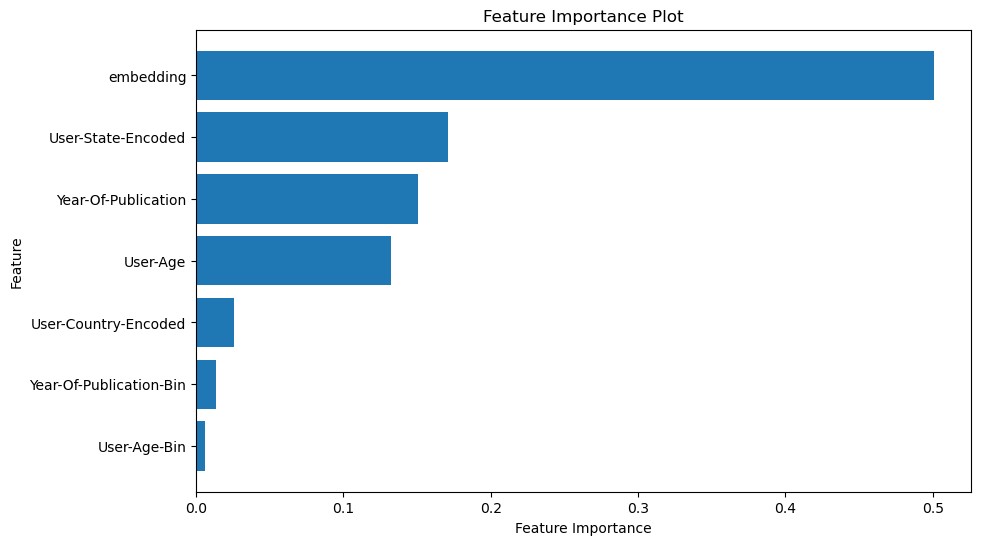

In [34]:
# find out the important features
dt_model.fit(x, y)
feature_importances = dt_model.feature_importances_
feature_names = x.columns 
sorted_index = np.argsort(feature_importances)

plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_index)), feature_importances[sorted_index])
plt.yticks(range(len(sorted_index)), [feature_names[i] for i in sorted_index])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance Plot")
plt.show()

In [35]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
x = merged_data_scaled.drop(columns = ["Book-Rating", "Rating-Category", "Book-Author-Encoded", "Book-Publisher-Encoded"])
y = merged_data_scaled["Rating-Category"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)

# dicision Tree Classifier
dt_classifier = DecisionTreeClassifier()

# cross-validation for Decision Tree Classifier 
df_accuracy = cross_val_score(dt_classifier, x, y, cv=5, scoring="accuracy")
dt_f1 = cross_val_score(dt_classifier, x, y, cv=5, scoring="f1_macro")

# train Decision Tree Classifier 
dt_classifier.fit(x_train, y_train)
dt_predictions = dt_classifier.predict(x_test)

# compute Decision Tree Classifier metrics
dt_confusion_matrix = confusion_matrix(y_test, dt_predictions)
dt_classification_report = classification_report(y_test, dt_predictions)

# initialize KNN Classifier 
knn_classifier = KNeighborsClassifier()

# cross-validation for KNN Classifier
knn_accuracy = cross_val_score(knn_classifier, x, y, cv=5, scoring="accuracy")
knn_f1 = cross_val_score(knn_classifier, x, y, cv=5, scoring="f1_macro")

# train KNN Classifier 
knn_classifier.fit(x_train, y_train)
knn_predictions = dt_classifier.predict(x_test)

# compute KNN Classifier metrics
knn_confusion_matrix = confusion_matrix(y_test, knn_predictions)
knn_classification_report = classification_report(y_test, knn_predictions)

# print results
print("Decision Tree Classifier Metrics:")
print(f"Accuracy: {np.mean(df_accuracy):.4f}")
print(f"F1-score: {np.mean(dt_f1):.4f}")
print("Classification Report:")
print(dt_classification_report)

print("\n\n")

print("KNN Classifier Metrics:")
print(f"Accuracy: {np.mean(knn_accuracy):.4f}")
print(f"F1-score: {np.mean(knn_f1):.4f}")
print("Classification Report:")
print(knn_classification_report)


Decision Tree Classifier Metrics:
Accuracy: 0.2080
F1-score: 0.2035
Classification Report:
              precision    recall  f1-score   support

           1       0.27      0.28      0.27      8785
           2       0.20      0.20      0.20      7173
           3       0.27      0.26      0.27     10360
           4       0.19      0.19      0.19      6930
           5       0.27      0.27      0.27      7585

    accuracy                           0.24     40833
   macro avg       0.24      0.24      0.24     40833
weighted avg       0.24      0.24      0.24     40833




KNN Classifier Metrics:
Accuracy: 0.2177
F1-score: 0.2043
Classification Report:
              precision    recall  f1-score   support

           1       0.27      0.28      0.27      8785
           2       0.20      0.20      0.20      7173
           3       0.27      0.26      0.27     10360
           4       0.19      0.19      0.19      6930
           5       0.27      0.27      0.27      7585

    accura

In [37]:
# the end